In [1]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 2.2.1     ✔ purrr   0.2.4
✔ tibble  1.4.2     ✔ dplyr   0.7.4
✔ tidyr   0.8.0     ✔ stringr 1.3.0
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()


# Lecture 10: Tidy data
In this notebook, we cover:

* [Tidy data](#Tidy-data)
* [Gather](#Gather)
* [Spread](#Spread)
* [Separating and uniting data](#Separating-and-uniting-data)
* [Missing values](#Missing-values)

## Tidy data
There are many different ways to represent data in a table, but some are better than others.
We say that a data table is "[tidy](http://vita.had.co.nz/papers/tidy-data.pdf)" if:
- Each row represents an observation.
- Each column represents a variable.
- Each value gets its own cell.
- Each different type of data set gets its own table.

Data tables which are not tidy are called messy!
![http://r4ds.had.co.nz/images/tidy-1.png](http://r4ds.had.co.nz/images/tidy-1.png)

Every column is a variable: tidy.

In [2]:
print(table1)

# A tibble: 6 x 4
  country      year  cases population
  <chr>       <int>  <int>      <int>
1 Afghanistan  1999    745   19987071
2 Afghanistan  2000   2666   20595360
3 Brazil       1999  37737  172006362
4 Brazil       2000  80488  174504898
5 China        1999 212258 1272915272
6 China        2000 213766 1280428583


Variables are entries in the type column: messy.

In [3]:
print(table2) # 

# A tibble: 12 x 4
   country      year type            count
   <chr>       <int> <chr>           <int>
 1 Afghanistan  1999 cases             745
 2 Afghanistan  1999 population   19987071
 3 Afghanistan  2000 cases            2666
 4 Afghanistan  2000 population   20595360
 5 Brazil       1999 cases           37737
 6 Brazil       1999 population  172006362
 7 Brazil       2000 cases           80488
 8 Brazil       2000 population  174504898
 9 China        1999 cases          212258
10 China        1999 population 1272915272
11 China        2000 cases          213766
12 China        2000 population 1280428583


The cases and population variables are combined in the rate column: (sort of) messy.

In [4]:
print(table3)

# A tibble: 6 x 3
  country      year rate             
* <chr>       <int> <chr>            
1 Afghanistan  1999 745/19987071     
2 Afghanistan  2000 2666/20595360    
3 Brazil       1999 37737/172006362  
4 Brazil       2000 80488/174504898  
5 China        1999 212258/1272915272
6 China        2000 213766/1280428583


The cases and population variables are in two separate tables. 

In [5]:
print(table4a) # cases in one tibble
writeLines("\n")
print(table4b) # population in another one

# A tibble: 3 x 3
  country     `1999` `2000`
* <chr>        <int>  <int>
1 Afghanistan    745   2666
2 Brazil       37737  80488
3 China       212258 213766


# A tibble: 3 x 3
  country         `1999`     `2000`
* <chr>            <int>      <int>
1 Afghanistan   19987071   20595360
2 Brazil       172006362  174504898
3 China       1272915272 1280428583


Recapping: tidy data means

* each observation has its own row
* each variable has its own column
* each value has its own cell

## Why we care about tidy data
The tools we have learned so far all live in the `tidyverse`. This means that each tool expect to recieve tidy data as input, and, where necessary, returns tidy data as output. You can think of tidy data as a sort of contract that everything in `tidyverse` respects. This makes it possible to string many tidyverse commands together using `%>%`  (without having to worry too much about whether it will work.)

The mutate command expects tidy data and returns tidy data.

In [39]:
mutate(table1, rate = cases / population * 10000) # rate of cases per 10000 people

  country     year cases  population rate    
1 Afghanistan 1999    745   19987071 0.372741
2 Afghanistan 2000   2666   20595360 1.294466
3 Brazil      1999  37737  172006362 2.193930
4 Brazil      2000  80488  174504898 4.612363
5 China       1999 212258 1272915272 1.667495
6 China       2000 213766 1280428583 1.669488

How would we calculate the `rate` variable using `table2`?

In [7]:
print(table2)
# mutate(table2, rate=???)

# A tibble: 12 x 4
   country      year type            count
   <chr>       <int> <chr>           <int>
 1 Afghanistan  1999 cases             745
 2 Afghanistan  1999 population   19987071
 3 Afghanistan  2000 cases            2666
 4 Afghanistan  2000 population   20595360
 5 Brazil       1999 cases           37737
 6 Brazil       1999 population  172006362
 7 Brazil       2000 cases           80488
 8 Brazil       2000 population  174504898
 9 China        1999 cases          212258
10 China        1999 population 1272915272
11 China        2000 cases          213766
12 China        2000 population 1280428583


Summary commands like `summarize` and `count` also preserve tidy data:

In [8]:
count(table1, year, wt = cases) # compute no. of cases for each year

  year n     
1 1999 250740
2 2000 296920

`ggplot` also expects tidy data:

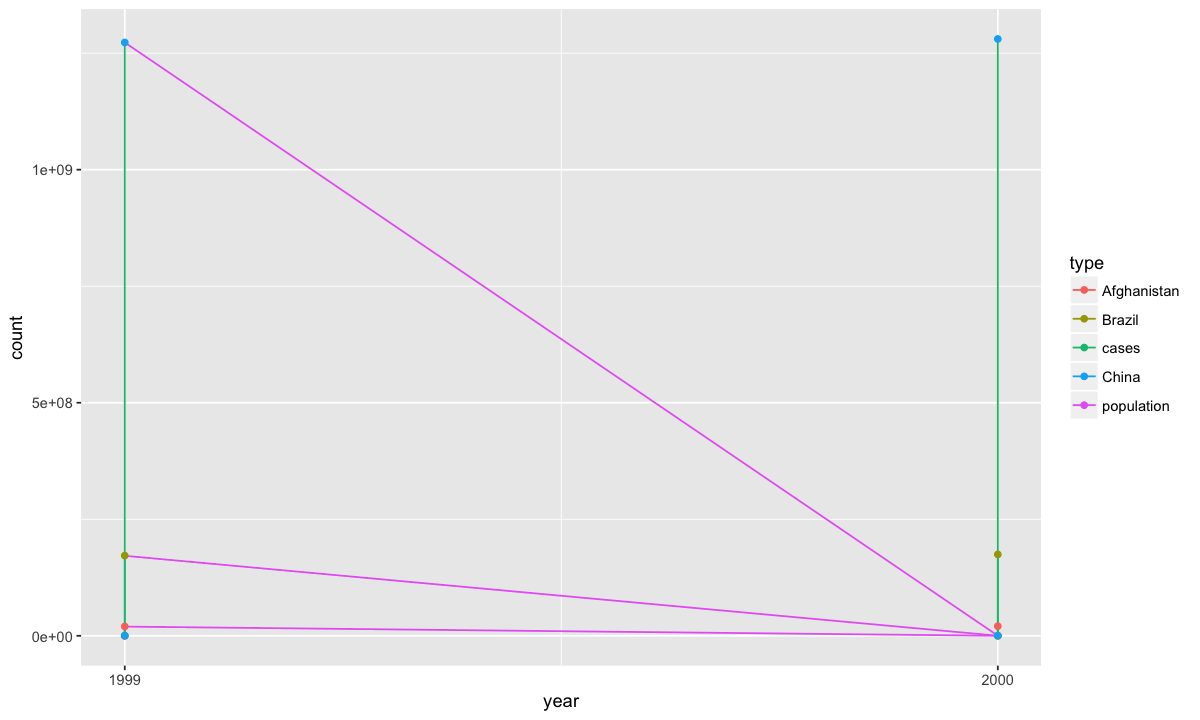

In [43]:
ggplot(table2, aes(x=year, y=count, color=type)) +
    geom_line(aes(group = country)) +
    geom_point(aes(color = country)) +
    scale_x_continuous(breaks=c(1999, 2000))

## Creating tidy data
If the data is not already tidy, then we might need to some work before we can use the tools in `dplyr`. The package `tidyr` inside `tidyverse` allows one to convert data into the tidy data.

### Gather
One common problem in when a variable is spread across multiple columns and we need to gather those columns to create a new pair of variables. For example, consider `table4a` from above:

In [74]:
print(table1)
table1 %>% spread(key=country, value=cases)

# A tibble: 6 x 4
  country      year  cases population
  <chr>       <int>  <int>      <int>
1 Afghanistan  1999    745   19987071
2 Afghanistan  2000   2666   20595360
3 Brazil       1999  37737  172006362
4 Brazil       2000  80488  174504898
5 China        1999 212258 1272915272
6 China        2000 213766 1280428583


  year population Afghanistan Brazil China 
1 1999   19987071  745           NA      NA
2 1999  172006362   NA        37737      NA
3 1999 1272915272   NA           NA  212258
4 2000   20595360 2666           NA      NA
5 2000  174504898   NA        80488      NA
6 2000 1280428583   NA           NA  213766

Here there is a year variable which is spread across two columns. To become tidy, it should get its own `year` column. We want to *gather* the columns of year into a single column.
![gather illustration](http://r4ds.had.co.nz/images/tidy-9.png)

The command to do this is called `gather()`. To use `gather()` we need to specify three things:

* which existing columns correspond to values of a variable
* what is the name of the variable (the **key**) whose values currently appear as column names
* what is the name of the variable (the **value**) whose values are currently spread over the cells 

In [50]:
print(table4b)

# A tibble: 3 x 3
  country         `1999`     `2000`
* <chr>            <int>      <int>
1 Afghanistan   19987071   20595360
2 Brazil       172006362  174504898
3 China       1272915272 1280428583


Above, the **key** is the variable **year** and the **value** is the variable **cases**.

In [49]:
(tidy4a = table4a %>% gather(`1999`, `2000`, key = year, value = cases))

  country     year cases 
1 Afghanistan 1999    745
2 Brazil      1999  37737
3 China       1999 212258
4 Afghanistan 2000   2666
5 Brazil      2000  80488
6 China       2000 213766

A similar `gather` command will work to create the **year** and **population** variables from `table4b`. 

In [54]:
(tidy4b = table4b %>% gather(`1999`, `2000`, key = "year", value = population))

  country     year population
1 Afghanistan 1999   19987071
2 Brazil      1999  172006362
3 China       1999 1272915272
4 Afghanistan 2000   20595360
5 Brazil      2000  174504898
6 China       2000 1280428583

To recreate `table1` we need to join these table:

In [14]:
left_join(tidy4a, tidy4b)

Joining, by = c("country", "year")


  country     year cases  population
1 Afghanistan 1999    745   19987071
2 Brazil      1999  37737  172006362
3 China       1999 212258 1272915272
4 Afghanistan 2000   2666   20595360
5 Brazil      2000  80488  174504898
6 China       2000 213766 1280428583

### Spread
Another type of problem in when an observation is scattered across multiple rows.

In [15]:
print(table2)

# A tibble: 12 x 4
   country      year type            count
   <chr>       <int> <chr>           <int>
 1 Afghanistan  1999 cases             745
 2 Afghanistan  1999 population   19987071
 3 Afghanistan  2000 cases            2666
 4 Afghanistan  2000 population   20595360
 5 Brazil       1999 cases           37737
 6 Brazil       1999 population  172006362
 7 Brazil       2000 cases           80488
 8 Brazil       2000 population  174504898
 9 China        1999 cases          212258
10 China        1999 population 1272915272
11 China        2000 cases          213766
12 China        2000 population 1280428583


Here we want to do the opposite of gather: we want to *spread* these rows out into new columns.
![spread data](http://r4ds.had.co.nz/images/tidy-8.png)

We need to specify two things:

* which existing column (the **key**) has the variable names as values
* which existing column (the **value**) has the values for those variables

In [56]:
table2 %>% spread(key = type, value = count)
#spread(table2, key = type, value = count)

  country     year cases  population
1 Afghanistan 1999    745   19987071
2 Afghanistan 2000   2666   20595360
3 Brazil      1999  37737  172006362
4 Brazil      2000  80488  174504898
5 China       1999 212258 1272915272
6 China       2000 213766 1280428583

Remember that:

* `gather` tends to make wide tables narrower and longer
* `spread` tends to make long tables shorter and wider

In [89]:
(stocks <- tibble(
  year   = c(2015, 2015, 2016, 2016),
  half   = c(   1,    2,    1,    2),
  return = c(1.88, 0.59, 0.92, 0.17)
))
stocks  %>% unite(yh, year, half, sep="-") %>% spread(key=yh, value=return)

  year half return
1 2015 1    1.88  
2 2015 2    0.59  
3 2016 1    0.92  
4 2016 2    0.17  

  2015-1 2015-2 2016-1 2016-2
1 1.88   0.59   0.92   0.17  

Let us now spread this tibble with **year** as key and **return** as value.

In [62]:
stocks %>% spread(key = half, value = return)

  year 1    2   
1 2015 1.88 0.59
2 2016 0.92 0.17

Let us now gather the columns to get back tidy data.

In [67]:
gather(spread_stocks, `2015`, `2016`, key = year, value = return) %>% mutate(year = as.integer(year)) %>% print


# A tibble: 4 x 3
   half  year return
  <dbl> <int>  <dbl>
1     1  2015   1.88
2     2  2015   0.59
3     1  2016   0.92
4     2  2016   0.17


Looks the same as **stocks**, doesn't it? The columns are ordered differently, but we can fix that.

In [20]:
(stocks_new <- select(stocks_new, year, half, return))
stocks

  year half return
1 2015 1    1.88  
2 2015 2    0.59  
3 2016 1    0.92  
4 2016 2    0.17  

  year half return
1 2015 1    1.88  
2 2015 2    0.59  
3 2016 1    0.92  
4 2016 2    0.17  

They look pretty much the same but let us examine the **types** of the variables.

In [21]:
print(stocks)

# A tibble: 4 x 3
   year  half return
  <dbl> <dbl>  <dbl>
1  2015     1   1.88
2  2015     2   0.59
3  2016     1   0.92
4  2016     2   0.17


In [22]:
print(stocks_new)

# A tibble: 4 x 3
  year   half return
  <chr> <dbl>  <dbl>
1 2015      1   1.88
2 2015      2   0.59
3 2016      1   0.92
4 2016      2   0.17


The **year** variable used to be of type **dbl** but is now **chr**. We can fix this too.

In [23]:
stocks_new <- mutate(stocks_new, year = as.double(year))
print(stocks_new)

# A tibble: 4 x 3
   year  half return
  <dbl> <dbl>  <dbl>
1  2015     1   1.88
2  2015     2   0.59
3  2016     1   0.92
4  2016     2   0.17


### Challenge Problem
Is the table below tidy? If not, how should we tidy it?

In [78]:
(preg = tribble(
  ~pregnant, ~male, ~female,
  "yes",     NA,    10,
  "no",      20,    12
))
preg %>% gather(male, female, key=gender, value=n)

  pregnant male female
1 yes      NA   10    
2 no       20   12    

  pregnant gender n 
1 yes      male   NA
2 no       male   20
3 yes      female 10
4 no       female 12

## Separating and uniting data
Above we saw `table3` which had a different type of messiness: two variables were combined into one `rate` column:

In [25]:
print(table3)

# A tibble: 6 x 3
  country      year rate             
* <chr>       <int> <chr>            
1 Afghanistan  1999 745/19987071     
2 Afghanistan  2000 2666/20595360    
3 Brazil       1999 37737/172006362  
4 Brazil       2000 80488/174504898  
5 China        1999 212258/1272915272
6 China        2000 213766/1280428583


To pull apart these two variables we have the `separate()` function. `separate()` takes the name of the column to separate, a separator (in this case `'/'`), and the names of the columns to separate into.

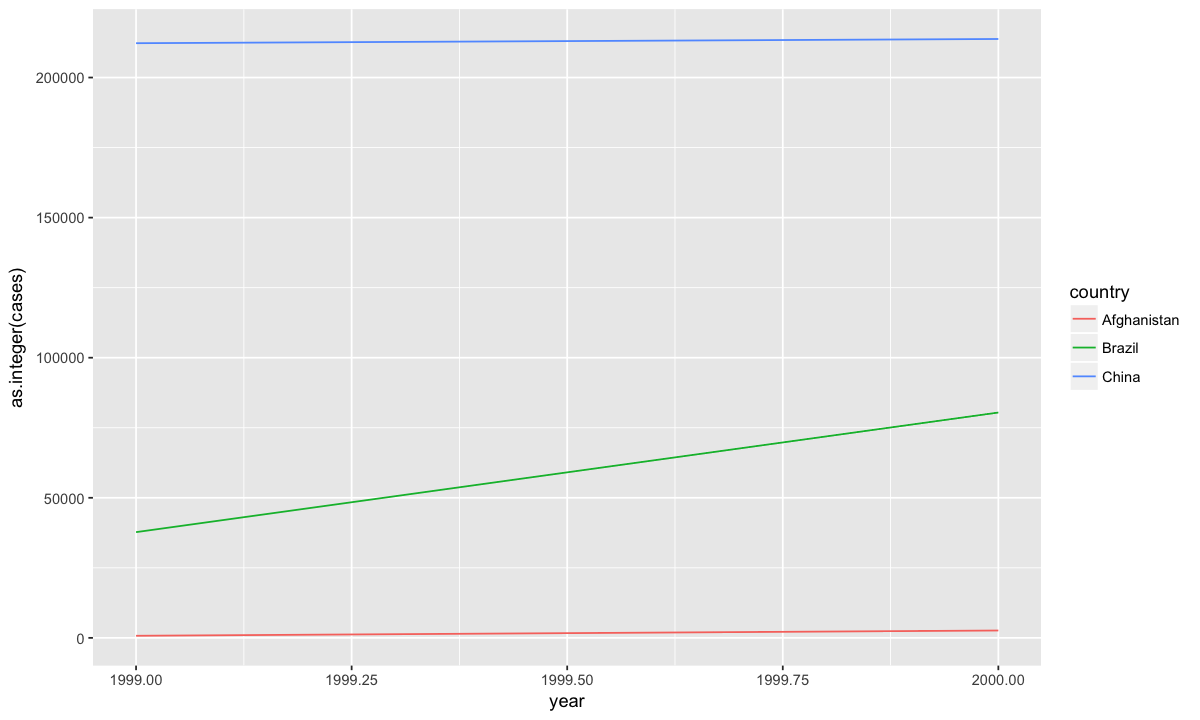

In [85]:
separated_table3 <- separate(table3, rate, into = c("cases", "population"), sep = "/")
ggplot(separated_table3) + geom_line(aes(x=year, y=as.integer(cases), color=country))

By default, `separate()` has coded `cases` and `population` as strings. To do further analysis we should convert them to integers:

In [27]:
print(mutate(separated_table3, cases = as.integer(cases), population = as.integer(population)))

# A tibble: 6 x 4
  country      year  cases population
  <chr>       <int>  <int>      <int>
1 Afghanistan  1999    745   19987071
2 Afghanistan  2000   2666   20595360
3 Brazil       1999  37737  172006362
4 Brazil       2000  80488  174504898
5 China        1999 212258 1272915272
6 China        2000 213766 1280428583


`separate()` will do this for us if we ask:

In [86]:
(separated_table3 <- separate(table3, rate, into = c("cases", "population"), sep = "/", convert = TRUE)) %>% print

# A tibble: 6 x 4
  country      year  cases population
* <chr>       <int>  <int>      <int>
1 Afghanistan  1999    745   19987071
2 Afghanistan  2000   2666   20595360
3 Brazil       1999  37737  172006362
4 Brazil       2000  80488  174504898
5 China        1999 212258 1272915272
6 China        2000 213766 1280428583


### Uniting
In some cases we need to do the opposite of `separate()`: stick two variables together to form a new variable. The tool for this is called `unite()`.

In [29]:
(separated_year <- separate(table3, year, into = c("century", "year"), sep = 2))

  country     century year rate             
1 Afghanistan 19      99   745/19987071     
2 Afghanistan 20      00   2666/20595360    
3 Brazil      19      99   37737/172006362  
4 Brazil      20      00   80488/174504898  
5 China       19      99   212258/1272915272
6 China       20      00   213766/1280428583

In [30]:
print(separated_year)

# A tibble: 6 x 4
  country     century year  rate             
* <chr>       <chr>   <chr> <chr>            
1 Afghanistan 19      99    745/19987071     
2 Afghanistan 20      00    2666/20595360    
3 Brazil      19      99    37737/172006362  
4 Brazil      20      00    80488/174504898  
5 China       19      99    212258/1272915272
6 China       20      00    213766/1280428583


In this table the century and year have been split apart. To combine them we can use `unite()`:

In [31]:
unite(separated_year, new, century, year)

  country     new   rate             
1 Afghanistan 19_99 745/19987071     
2 Afghanistan 20_00 2666/20595360    
3 Brazil      19_99 37737/172006362  
4 Brazil      20_00 80488/174504898  
5 China       19_99 212258/1272915272
6 China       20_00 213766/1280428583

By default, `unite()` adds a `_` between the united variables. In this case, we want there to be no separator so that we can treat the resulting `year` variable as an integer:

In [32]:
unite(separated_year, new, century, year, sep = "")

  country     new  rate             
1 Afghanistan 1999 745/19987071     
2 Afghanistan 2000 2666/20595360    
3 Brazil      1999 37737/172006362  
4 Brazil      2000 80488/174504898  
5 China       1999 212258/1272915272
6 China       2000 213766/1280428583

## Missing Values
Missing values can be:

* **Explicit** (marked as `NA` in our data); or
* **Implicit** (not present in the data).

In [90]:
(stocks <- tibble(
  year   = c(2015, 2015, 2015, 2015, 2016, 2016, 2016),
  qtr    = c(   1,    2,    3,    4,    2,    3,    4),
  return = c(1.88, 0.59, 0.35,   NA, 0.92, 0.17, 2.66)
))

  year qtr return
1 2015 1   1.88  
2 2015 2   0.59  
3 2015 3   0.35  
4 2015 4     NA  
5 2016 2   0.92  
6 2016 3   0.17  
7 2016 4   2.66  

In this example we have one explicitly missing value for the 4th quarter of 2015. Are there any other missing values? Yes, because we do not have an observation for the first quarter of 2016.

The **complete** command makes implicit missing value explicit by considering all combinations of unique values of specified variables.

In [34]:
complete(stocks, year, qtr) 

  year qtr return
1 2015 1   1.88  
2 2015 2   0.59  
3 2015 3   0.35  
4 2015 4     NA  
5 2016 1     NA  
6 2016 2   0.92  
7 2016 3   0.17  
8 2016 4   2.66  

The missing values also become explicit if we **spread** the tibble.

In [35]:
spread(stocks, key = year, value = return)

  qtr 2015 2016
1 1   1.88   NA
2 2   0.59 0.92
3 3   0.35 0.17
4 4     NA 2.66

**gather** will keep all these explicitly missing values by default.

In [36]:
stocks %>%
    spread(key = year, value = return) %>%
    gather(`2015`, `2016`, key = year, value = return)

  qtr year return
1 1   2015 1.88  
2 2   2015 0.59  
3 3   2015 0.35  
4 4   2015   NA  
5 1   2016   NA  
6 2   2016 0.92  
7 3   2016 0.17  
8 4   2016 2.66  

If you don't like the default behavior of **gather**, you can turn off explicit missing values using the `na.rm` argument.

In [37]:
stocks %>%
    spread(key = year, value = return) %>%
    gather(`2015`, `2016`, key = year, value = return, na.rm = TRUE)

  qtr year return
1 1   2015 1.88  
2 2   2015 0.59  
3 3   2015 0.35  
6 2   2016 0.92  
7 3   2016 0.17  
8 4   2016 2.66  

**Imputation** refers to process of filling in missing values. There are many imputation methods. One of the simplest ones is *last observation carry forward*. You can do that using the **fill** command.

In [93]:
stocks %>% complete(year, qtr) %>% fill(return)

  year qtr return
1 2015 1   1.88  
2 2015 2   0.59  
3 2015 3   0.35  
4 2015 4   0.35  
5 2016 1   0.35  
6 2016 2   0.92  
7 2016 3   0.17  
8 2016 4   2.66  